Using limma for key cluster DEG analysis

In [1]:
library(limma)
library(dplyr)
library(ggplot2)
library(edgeR)
library(stringr)
library(reshape2)
library(ggrepel)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [19]:
# read the voom normalised data
exp_df <- read.csv('/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Code/Tahoe_DEG_pre_data.csv', header = T, row.names = 1)    
head(exp_df)

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,⋯,ENSG00000291308,LY6S,ENSG00000291310,ENSG00000291312,ENSG00000291313,ENSG00000291314,ENSG00000291315,ENSG00000291316,TMEM276,Tahoe_category
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
DMSO_Plate_7_CVCL_0023,3.5165577,-2.7872231,6.527926,2.994137,4.201462,-2.7872231,2.257171,4.525660,6.568128,4.696593,⋯,-2.7872231,-2.7872231,-2.7872231,-2.7872231,-2.7872231,-2.7872231,-2.7872231,-1.2022606,2.8274868,High Score
DMSO_Plate_7_CVCL_0028,4.8581391,-0.7565708,6.185944,2.413354,4.858139,-0.7565708,1.565357,5.510216,6.592157,6.185944,⋯,-0.7565708,-0.7565708,-0.7565708,-0.7565708,-0.7565708,-0.7565708,-0.7565708,-0.7565708,2.4133542,Low Score
DMSO_Plate_7_CVCL_0069,2.5878695,-2.7696825,6.850537,3.738112,4.349259,-2.7696825,3.338842,5.031217,5.291013,4.449486,⋯,-2.7696825,-2.7696825,-2.7696825,-2.7696825,-2.7696825,-2.7696825,-2.7696825,-2.7696825,2.0882985,Low Score
DMSO_Plate_7_CVCL_0099,2.4412249,-2.0823371,6.809447,3.750553,3.750553,-2.0823371,6.445140,6.112420,5.368874,5.318542,⋯,-2.0823371,-2.0823371,-2.0823371,-2.0823371,-2.0823371,-2.0823371,-2.0823371,-2.0823371,-0.4973746,Low Score
DMSO_Plate_7_CVCL_0131,-0.7433165,-2.3282790,6.191357,3.226310,4.358222,-2.3282790,1.578612,4.590584,4.769753,4.769753,⋯,-2.3282790,-2.3282790,-2.3282790,-2.3282790,-2.3282790,-2.3282790,-2.3282790,-0.7433165,2.7161151,Low Score
DMSO_Plate_7_CVCL_0152,3.6176312,-2.4484580,7.740131,3.617631,4.265787,-2.4484580,1.010974,4.808930,7.100364,5.654830,⋯,-2.4484580,-2.4484580,-2.4484580,-2.4484580,-2.4484580,-2.4484580,-2.4484580,-2.4484580,2.3064295,High Score


In [20]:
# Identify the column index for the category
cat_col_name <- "Tahoe_category"

# Extract the metadata (keep as dataframe)
# We use base R subsetting because input_df is a matrix
metadata_df <- data.frame(Tahoe_category = exp_df[, cat_col_name])
rownames(metadata_df) <- rownames(exp_df)

In [21]:
# Extract the expression part (remove the category column)
exp_matrix_char <- exp_df[, colnames(exp_df) != cat_col_name]

In [22]:
# CRITICAL STEP: Convert the expression matrix from "Character" to "Numeric"
# (Since it was a text matrix, we must force it back to numbers)
mode(exp_matrix_char) <- "numeric"

ERROR: Error in mde(x): 'list' object cannot be coerced to type 'double'


In [23]:
# Transpose: Limma needs Genes as Rows, Samples as Columns
exp_matrix <- t(exp_matrix_char)

In [24]:
# Ensure metadata factors are set correctly (Ref = Low Score)
metadata_df$Tahoe_category <- factor(metadata_df$Tahoe_category, 
                                     levels = c("Low Score", "High Score"))

In [25]:
# Check dimensions to be safe
cat("Expression Matrix Dimensions:", dim(exp_matrix), "\n") # Should be ~62k genes x 150 samples
cat("Metadata Dimensions:", dim(metadata_df), "\n")         # Should be 150 samples x 1 col

Expression Matrix Dimensions: 62710 150 
Metadata Dimensions: 150 1 


In [26]:
# ---------------------------------------------------------
# 2. Differential Expression Analysis (Limma)
# ---------------------------------------------------------

# Create Design Matrix
design_mat <- model.matrix(~ Tahoe_category, data = metadata_df)

In [27]:
# Linear Fitting
fit <- lmFit(exp_matrix, design_mat)
fit2 <- eBayes(fit, trend = TRUE)

In [29]:
# Get Results (High Score vs Low Score)
res <- topTable(fit2, coef = 2, number = Inf)

In [30]:
# Filter for significant genes
significant_genes <- res %>%
  filter(abs(logFC) > 1 & adj.P.Val < 0.05)

cat("Number of significant genes:", nrow(significant_genes), "\n")

Number of significant genes: 1188 


In [31]:
# ---------------------------------------------------------
# 3. Volcano Plot
# ---------------------------------------------------------

# Prepare data for plotting
df_plot <- res
df_plot$gene_symbol <- rownames(df_plot)

# Define Significance categories
df_plot$sig <- "Non-significant"
df_plot$sig[df_plot$logFC > 1 & df_plot$adj.P.Val < 0.05] <- "Upregulated"
df_plot$sig[df_plot$logFC < -1 & df_plot$adj.P.Val < 0.05] <- "Downregulated"


In [32]:
# Select top genes to label (Top 10 by p-value among significant ones)
top_N_genes <- df_plot %>%
  filter(sig != "Non-significant") %>%
  arrange(adj.P.Val) %>%
  head(10) %>%
  pull(gene_symbol)

df_plot$top_gene <- ifelse(df_plot$gene_symbol %in% top_N_genes, df_plot$gene_symbol, NA)

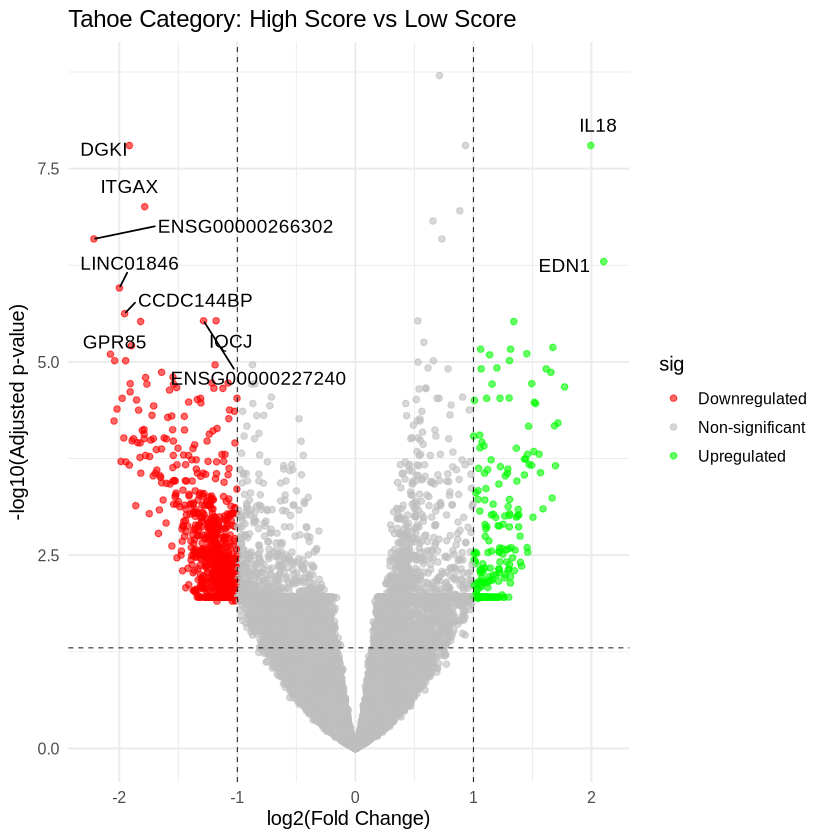

In [33]:
# Generate Plot
P <- ggplot(df_plot, aes(x = logFC, y = -log10(adj.P.Val), color = sig)) +
  geom_point(alpha = 0.6) +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "black", linewidth = 0.25) +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "black", linewidth = 0.25) +
  geom_text_repel(
    aes(label = top_gene),
    size = 4,
    color = "black",
    box.padding = 0.5,
    max.overlaps = 50,
    na.rm = TRUE
  ) +
  scale_color_manual(
    values = c(
      "Downregulated" = "red",
      "Upregulated" = "green",
      "Non-significant" = "grey"
    )
  ) +
  labs(
    title = "Tahoe Category: High Score vs Low Score",
    x = "log2(Fold Change)",
    y = "-log10(Adjusted p-value)"
  ) +
  theme_minimal(base_size = 12)

print(P)

In [34]:
# Save all DE results
write.csv(
  res,
  file = "Tahoe_limma_DE_genes.csv",
  row.names = TRUE
)
